In [1]:
import os

def load_data( folders ):
    'folders：包含多个文件目录的列表或者一个文件目录的字符串'
    print('folders',len(folders ))
    if type(folders).__name__ == 'str':
        folders = [folders]
        
    pic_paths = []
    labels = []        
    for folder in folders:
        print(folder)
        for root, dirs, files in os.walk(folder):
            if len(files) > 800:
                files = files[:800]
            if root[-4:-1] == 'neg':
                label = 1
            else:
                label = 0
            for file in files:
                name = os.path.join(root ,file)
                pic_paths.append(name)                             
                labels.append(label)
    print('总样本数：',len(labels),'\n')
    
    # 把 1/5 的样本用作测试，4/5  用作训练
    test_pic_paths = []
    train_pic_paths  = []
    test_labels  = []
    train_labels  = []
    num_neg = 0
    train_neg = 0
    test_neg = 0
    for i in range(len(pic_paths) ):
        if labels[i]:
             num_neg = num_neg + 1
       
        if i %  5 ==0:
            if labels[i]:
                test_neg = test_neg + 1
            test_pic_paths.append( pic_paths[i] )
            test_labels.append( labels[i] )
        else:
            if labels[i]:
                 train_neg = train_neg + 1           
            train_pic_paths.append( pic_paths[i] )
            train_labels.append( labels[i] )
    print('num_neg(%u),train_neg(%u),test_neg(%u)'%(num_neg,train_neg,test_neg))
    N_train = len(train_pic_paths)
    N_test  = len(test_labels)
    print('N_train(%u),N_test(%u)'%(N_train,N_test))
    print('load_data Done!!!\n')
    
    return train_pic_paths,train_labels,  test_pic_paths,test_labels,  N_train,N_test
                

# folders =   ["F:/Data/data_C1/neg/",  "F:/Data/data_C1/pos/",
#                  "F:/Data/data_C2/neg/",  "F:/Data/data_C2/pos/"]

# train_pic_paths,train_labels,  test_pic_paths,test_labels,  N_train,N_test = load_data( folders[:] )

In [2]:
import tensorflow as tf

def parse_function(pic_path, label):
# 图像读取和调整以使其成为方便训练的数据集
# 注意这里传进来的是单个图片的存储路径和类别
    img_string = tf.io.read_file(pic_path)
    img_decoded = tf.image.decode_image(img_string)                       # [   1200 1400  1]  解码图像

    img_crop = tf.image.crop_to_bounding_box(img_decoded,300,0,600,1400)  # [   600  1400  1]  固定裁剪
    img_random_crop = tf.image.random_crop(img_crop,[576,1152,1])         # [   576  1152  1]  随机裁剪

    img_random_brightness = tf.image.random_brightness(img_random_crop,0.2)  # 随机改变亮度

    img_reshape1 = tf.reshape(img_random_brightness,[1,576,1152,1])       # [1, 576  1152, 1]  增加维度
    img_resize = tf.image.resize(img_reshape1,[288, 576])                 # [1, 288, 576,  1]  压缩  uint8 ==>float32(0 to 255)
    img_reshape2 = tf.reshape(img_resize,[288, 576,1])                    # [   288, 576,  1]  减少维度


    img_random_flip_left_right = tf.image.random_flip_left_right(img_reshape2)           # 随机左右翻转
    img_random_flip_up_down = tf.image.random_flip_up_down(img_random_flip_left_right)   # 随机上下翻转
    
    img = img_random_flip_up_down / 127.5 -1 # [   288, 576,  1]  float32(0 to 255) ==> float32(-1 to 1)
    return img  ,label # ,  pic_path

def make_dataset(folders,batch_size):
    
    train_pic_paths,train_labels,  test_pic_paths,test_labels,  N_train,N_test = load_data(folders)
    # 高性能的训练数据集输入管道
    ds = tf.data.Dataset.from_tensor_slices((train_pic_paths, train_labels))
    print('1 建立数据集：',ds)
    ds = ds.repeat().shuffle(10000)             # shuffle_and_repeat
    print('2 复用再乱序：',ds)
    ds = ds.map(map_func=parse_function).batch(batch_size=batch_size)   # map_and_batch
    print('3 函数再批次：',ds)
    ds = ds.prefetch(buffer_size = batch_size )  # 预取 以提高 输入管道 的性能
    print('4 预取数据：  ',ds)

    # 验证数据集  不要  shuffle 但是要 repeat 操作
    val = tf.data.Dataset.from_tensor_slices((test_pic_paths, test_labels))
    val = val.repeat()#.shuffle(10000)
    val_no_batch = val.map(map_func=parse_function)           # map without batch
    val = val_no_batch.batch(batch_size=batch_size) 
    val = val.prefetch(buffer_size = batch_size )

    print('make_dataset done!\n')
    return ds, val,   N_train,N_test

folders 2
F:/Data/data_C1/neg/
F:/Data/data_C1/pos/
总样本数： 1000 

num_neg(500),train_neg(400),test_neg(100)
N_train(800),N_test(200)
load_data Done!!!

1 建立数据集： <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int32)>
2 复用再乱序： <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int32)>
Instructions for updating:
Colocations handled automatically by placer.
3 函数再批次： <DatasetV1Adapter shapes: ((?, 288, 576, 1), (?,)), types: (tf.float32, tf.int32)>
4 预取数据：   <DatasetV1Adapter shapes: ((?, 288, 576, 1), (?,)), types: (tf.float32, tf.int32)>
make_dataset done!

ds_batch_data:	 tuple 2
0


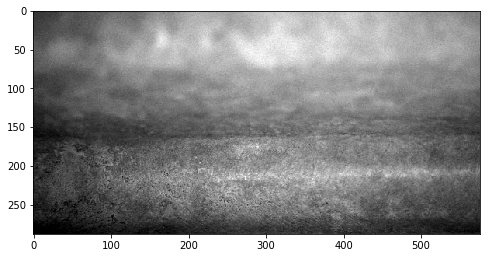

0


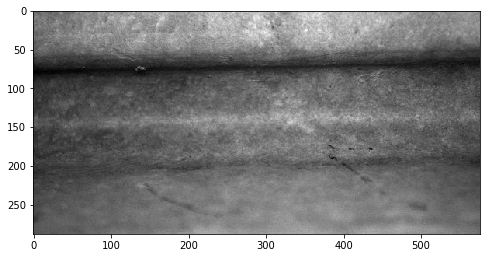

1


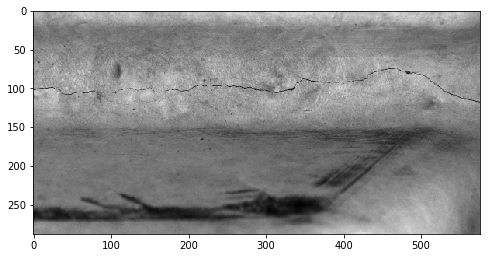

1


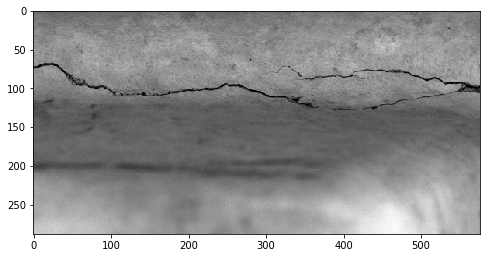

In [3]:
def p(name, x):
    try:
        print(name+':\t',type(x).__name__,x.shape)
    except:
        print(name+':\t',type(x).__name__,len(x))

        
if __name__=='__main__':
    import tensorflow as tf
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    folders =   ["F:/Data/data_C1/neg/",  "F:/Data/data_C1/pos/",
                 "F:/Data/data_C2/neg/",  "F:/Data/data_C2/pos/"]

    ds, val,   N_train,N_test = make_dataset(folders[:2],batch_size=4)
    ds_iterator = ds.make_one_shot_iterator()
    ds_next_element = ds_iterator.get_next()
    
    val_iterator = val.make_one_shot_iterator()
    val_next_element = val_iterator.get_next()
    
    with tf.Session() as sess:
        # 获得一个batch_size的ds数据
        ds_batch_data = sess.run(ds_next_element)
        p('ds_batch_data',ds_batch_data)
        pics   = ds_batch_data[0]
        labels = ds_batch_data[1]
#         paths  = ds_batch_data[2]
        for i in range( 4 ):
            print( labels[i] )
            img_val = pics[i,:,:,0]
#             p('img_val',img_val)
            plt.figure(figsize=[8,20])
            plt.imshow(img_val,cmap='gray')  #显示灰色图 img_val[:,:,0] 这样让[h,w,1]==>[h,w],实现降维
#             plt.title(str(i)+' '+str(paths[i])[2:])
            plt.show()    
            

#         print('--------------------------------------')
#         for i in range( 4 ):
#             val_batch_data = sess.run(val_next_element)
#             p('val_batch_data',val_batch_data)
#             pics   = val_batch_data[0]
#             labels = val_batch_data[1]
#             paths  = val_batch_data[2]
# #             p('pics',pics)
            
#             img_val = pics[:,:,0]
#             p('img_val',img_val)
#             plt.figure(figsize=[8,20])
#             plt.imshow(img_val,cmap='gray')  #显示灰色图 img_val[:,:,0] 这样让[h,w,1]==>[h,w],实现降维
#             plt.title(str(i)+' '+str(paths)[2:])
#             plt.show()  